<a href="https://colab.research.google.com/github/Katy-Kittivibul/Hybrid-Vector-Search-and-Retrieval-System-BigBasket-dataset-/blob/main/BigBasket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BigBasket**

This project will learn how to implement natural language processing (NLP) in prediction or classification tasks. The project contains 3 main topics.

1. Machine learning model
2. Deep learning model
3. Recommendation system



URL: https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints/data

## Import libraries

In [ ]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 25.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil, glob
from pathlib import Path
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments

import re
from sentence_transformers import SentenceTransformer
import faiss

## Import dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("surajjha101/bigbasket-entire-product-list-28k-datapoints")

print("Path to dataset files:", path)

100%|██████████| 6.04M/6.04M [00:00<00:00, 17.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints/versions/1


In [ ]:
base_data = os.listdir(path)
print("Files in the dataset folder:", base_data)

Files in the dataset folder: ['BigBasket Products.csv']


In [ ]:
csv_file = base_data[0]
data = os.path.join(path, csv_file)

The path variable provided by kagglehub points to a folder (the dataset directory), not the file itself. You must use os.path.join() to combine this folder path with the actual CSV file name to create the full, readable file path

## Data cleaning

In [ ]:
df = pd.read_csv(data)
print(df.head())

   index                                            product  \
0      1             Garlic Oil - Vegetarian Capsule 500 mg   
1      2                              Water Bottle - Orange   
2      3                     Brass Angle Deep - Plain, No.2   
3      4  Cereal Flip Lid Container/Storage Jar - Assort...   
4      5                 Creme Soft Soap - For Hands & Body   

                 category           sub_category              brand  \
0        Beauty & Hygiene              Hair Care  Sri Sri Ayurveda    
1  Kitchen, Garden & Pets  Storage & Accessories         Mastercook   
2    Cleaning & Household            Pooja Needs                Trm   
3    Cleaning & Household   Bins & Bathroom Ware             Nakoda   
4        Beauty & Hygiene       Bath & Hand Wash              Nivea   

   sale_price  market_price                      type  rating  \
0       220.0         220.0          Hair Oil & Serum     4.1   
1       180.0         180.0    Water & Fridge Bottles     2.3   

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB
None


In [ ]:
print(df.isnull().sum())

index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64


In [ ]:
df.dropna(subset=['product', 'brand'])
print(df.isnull().sum())

index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64


In [ ]:
# set columns for visualisation

numerical_cols = df.select_dtypes(include=[np.number]).columns
categorial_cols = df.select_dtypes(exclude=[np.number]).columns

numerical_cols = numerical_cols.drop('index')
categorial_cols = categorial_cols.drop('description')

print(numerical_cols)
print(categorial_cols)

Index(['sale_price', 'market_price', 'rating'], dtype='object')
Index(['product', 'category', 'sub_category', 'brand', 'type'], dtype='object')


## EDA

### Categorical data

In [ ]:
df["category"].value_counts()

,count
category,
Beauty & Hygiene,7867
Gourmet & World Food,4690
"Kitchen, Garden & Pets",3580
Snacks & Branded Foods,2814
"Foodgrains, Oil & Masala",2676
Cleaning & Household,2675
Beverages,885
"Bakery, Cakes & Dairy",851
Baby Care,610


In [ ]:
categorical_sum = df.groupby("category")[["sub_category", "type"]].value_counts().sort_values(ascending=False)
print(categorical_sum)

category                sub_category              type                 
Beauty & Hygiene        Skin Care                 Face Care                1503
                        Health & Medicine         Ayurveda                  537
                        Hair Care                 Shampoo & Conditioner     460
Kitchen, Garden & Pets  Storage & Accessories     Containers Sets           415
                        Crockery & Cutlery        Glassware                 415
                                                                           ... 
Snacks & Branded Foods  Pickles & Chutney         Instant Noodles             1
                        Ready To Cook & Eat       Frozen Indian Breads        1
                        Spreads, Sauces, Ketchup  Chips & Corn Snacks         1
                                                  Cookies                     1
                                                  Instant Noodles             1
Name: count, Length: 597, dtype: int64


In [ ]:
categorial_df = pd.DataFrame(categorical_sum)
display(categorial_df)

count
category               sub_category             type                        
Beauty & Hygiene       Skin Care                Face Care               1503
                       Health & Medicine        Ayurveda                 537
                       Hair Care                Shampoo & Conditioner    460
Kitchen, Garden & Pets Storage & Accessories    Containers Sets          415
                       Crockery & Cutlery       Glassware                415
...                                                                      ...
Snacks & Branded Foods Pickles & Chutney        Instant Noodles            1
                       Ready To Cook & Eat      Frozen Indian Breads       1
                       Spreads, Sauces, Ketchup Chips & Corn Snacks        1
                                                Cookies                    1
                                                Instant Noodles            1

[597 rows x 1 columns]

### Numerical data

In [ ]:
display(df.describe())

,index,sale_price,market_price,rating
count,27555.00000,27555.000000,27555.000000,18929.000000
mean,13778.00000,322.514808,382.056664,3.943410
std,7954.58767,486.263116,581.730717,0.739063
min,1.00000,2.450000,3.000000,1.000000
25%,6889.50000,95.000000,100.000000,3.700000
50%,13778.00000,190.000000,220.000000,4.100000
75%,20666.50000,359.000000,425.000000,4.300000
max,27555.00000,12500.000000,12500.000000,5.000000


In [ ]:
df["rating"].value_counts().sort_index(ascending=False)

,count
rating,
5.0,1407
4.9,53
4.8,199
4.7,287
4.6,322
4.5,798
4.4,1038
4.3,2140
4.2,2251


## Data visualisation

### Visualising Numerical Columns

1. Histograms: to show the distribution of data

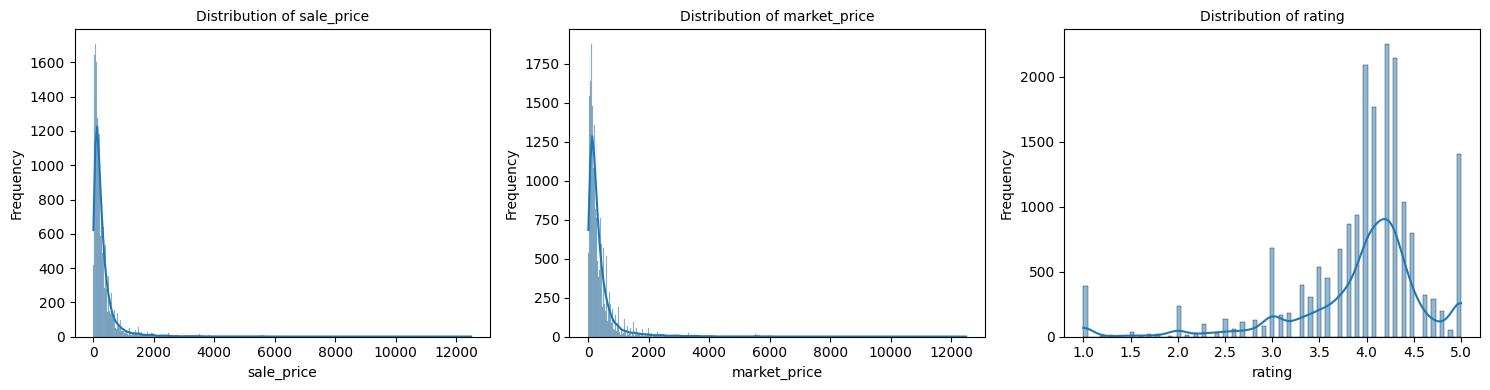

In [ ]:
num_plots = len(numerical_cols)
fig, axes = plt.subplots(1, num_plots, figsize=(15, 4))

for i, col in enumerate(numerical_cols):
  sns.histplot(df[col], ax=axes[i], kde=True)
  axes[i].set_title(f'Distribution of {col}', fontsize=10)
  axes[i].set_xlabel(col, fontsize=10)
  axes[i].set_ylabel('Frequency', fontsize=10)
  axes[i].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

2. Box plot: Identify the median, quartiles, and outliers.

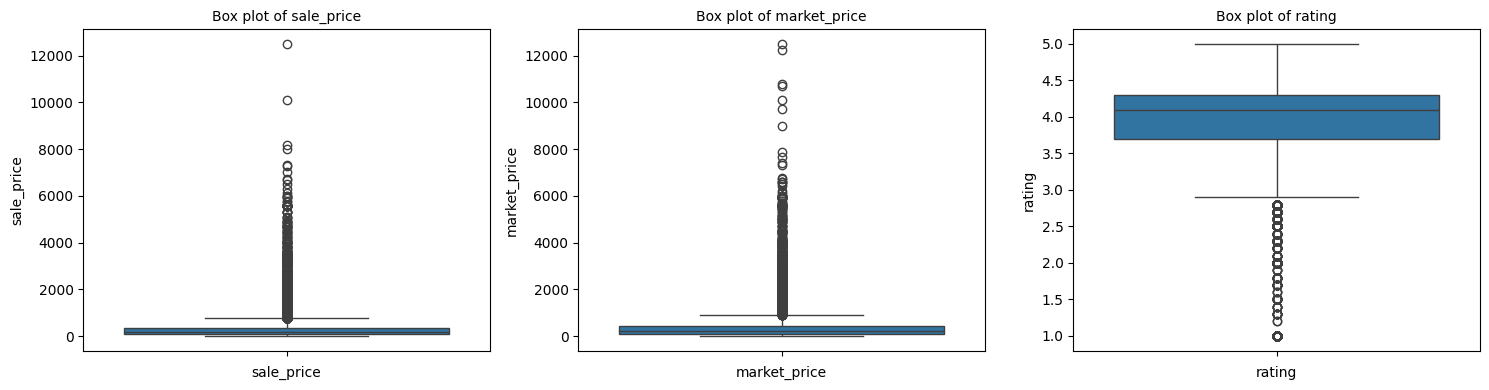

In [ ]:
num_plots = len(numerical_cols)
fig, axes = plt.subplots(1, num_plots, figsize=(15, 4))

for i, col in enumerate(numerical_cols):
  sns.boxplot(df[col], ax=axes[i])
  axes[i].set_title(f'Box plot of {col}', fontsize=10)
  axes[i].set_xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()

3. Pair plot: Show the relationship between numerical features

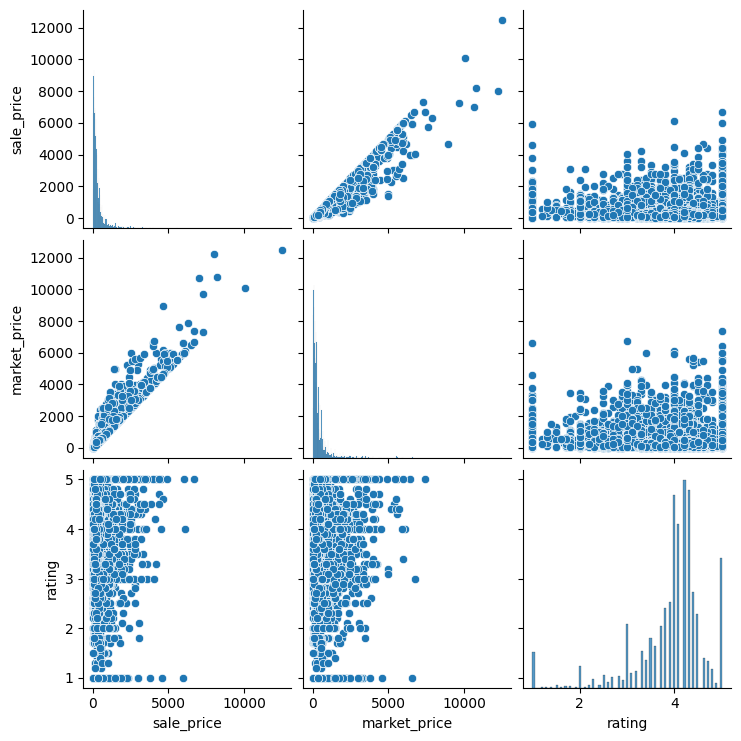

In [ ]:
sns.pairplot(df[numerical_cols])

4. Heat map: Show the relationship between numerical features

<Axes: >

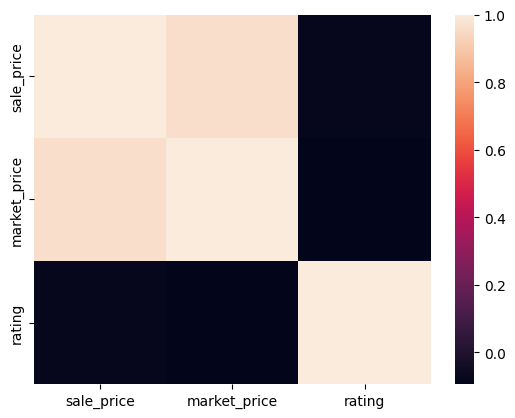

In [ ]:
sns.heatmap(df[numerical_cols].corr())

### Visualising Categorical Columns (Counts & Frequencies)

<Axes: xlabel='count', ylabel='category'>

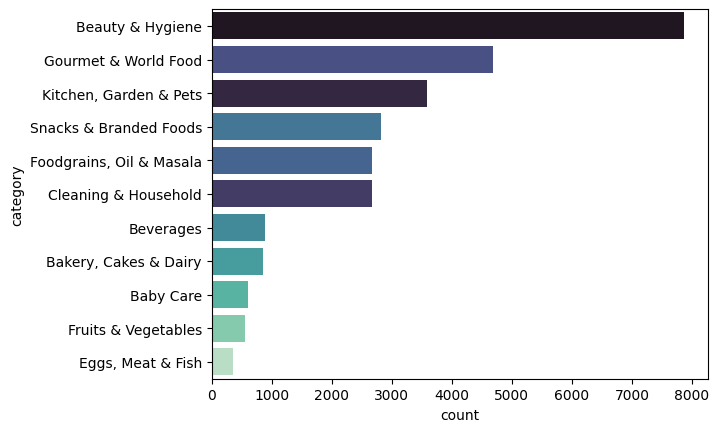

In [ ]:
sns.countplot(y=df['category'], order=df['category'].value_counts().index, hue=df['category'], palette="mako")

Text(0.5, 1.0, 'Top 10 Brands')

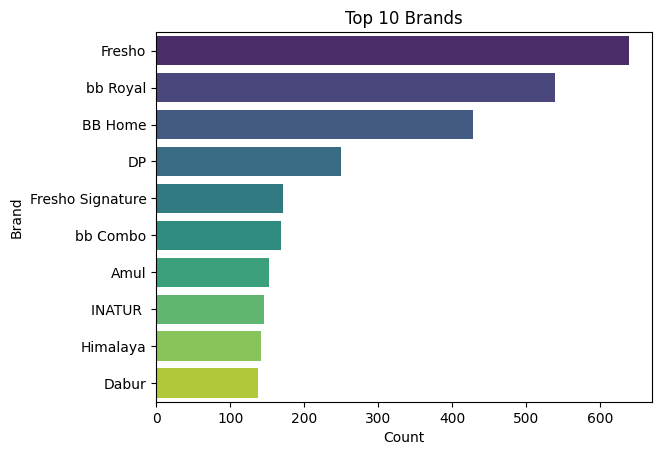

In [ ]:
top_brands = df['brand'].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index, hue=top_brands.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.title('Top 10 Brands')

# Machine learning

### Principal Component Analysis (PCA)

In [ ]:
pca_df = df[['category', 'sale_price', 'market_price']].copy()
pca_encoded = pd.get_dummies(pca_df, columns=['category'], drop_first=True) # turn categorical data into numerical data

In [ ]:
pca = pca_encoded
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca) # standardisation
pca_scaled_df = pd.DataFrame(pca_scaled, columns=pca.columns)

In [ ]:
# apply PCA
n_components = 2
pca_model = PCA(n_components=n_components)
pca_result = pca_model.fit_transform(pca_scaled_df)

In [ ]:
pca_cols = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(pca_result, columns=pca_cols)
print("PCA Resulting DataFrame (First 5 Rows):")
print(pca_df.head())

PCA Resulting DataFrame (First 5 Rows):
        PC1       PC2
0  0.088677  1.729799
1  0.177027 -1.248209
2 -0.751893 -0.350112
3 -0.794883 -0.343736
4 -0.053657  1.748176


In [ ]:
print("\nExplained Variance Ratio for each Principal Component:")
for i, ratio in enumerate(pca_model.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}% of total variance)")


Explained Variance Ratio for each Principal Component:
PC1: 0.1784 (17.84% of total variance)
PC2: 0.1086 (10.86% of total variance)


In [ ]:
# Map the original features (including one-hot encoded ones) to the components
loadings = pd.DataFrame(pca_model.components_.T, columns=pca_cols, index=pca.columns)
print("\nComponent Loadings (Feature Contribution):")
print(loadings.abs().sort_values(by='PC1', ascending=False).head(5))


Component Loadings (Feature Contribution):
                                      PC1       PC2
market_price                     0.652259  0.088831
sale_price                       0.648064  0.079821
category_Kitchen, Garden & Pets  0.207807  0.407777
category_Beauty & Hygiene        0.194917  0.802970
category_Snacks & Branded Foods  0.181294  0.037574


Text(0.5, 1.0, 'Explained Variance Ratio by Principal Components')

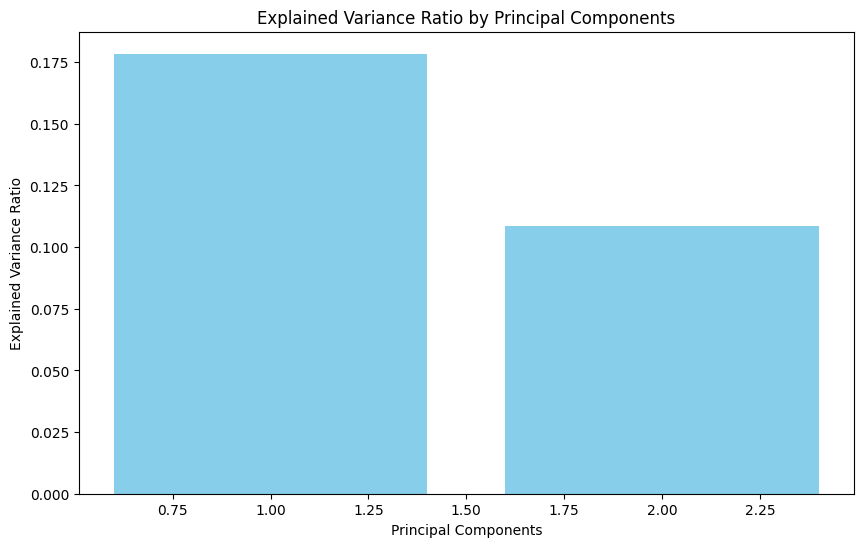

In [ ]:
explained_variance_ratio = pca_model.explained_variance_ratio_
components = range(1, len(explained_variance_ratio) + 1)

# Create the Scree Plot
plt.figure(figsize=(10, 6))
plt.bar(components, explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')

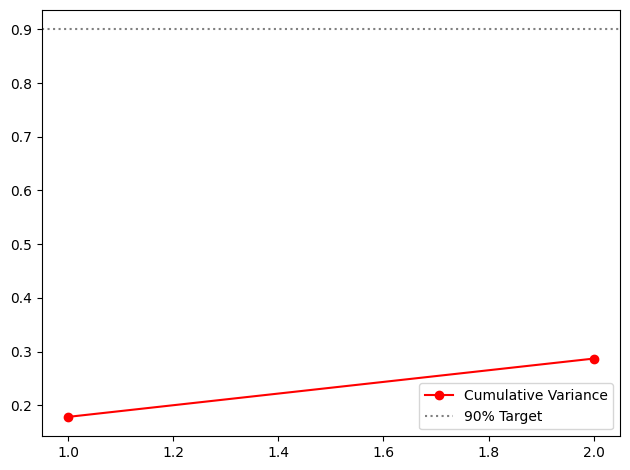

In [ ]:
# Add cumulative explained variance (optional but useful)
cumulative_variance = explained_variance_ratio.cumsum()
plt.plot(components, cumulative_variance, marker='o', linestyle='-', color='red', label='Cumulative Variance')
plt.axhline(0.90, color='grey', linestyle=':', label='90% Target') # Highlight a 90% target line
plt.legend()
plt.tight_layout()
plt.savefig('pca_scree_plot.png')
# plt.show()

# Deep learning (BERT)

This part will make the prediction model for "category" and "sub-category" sections when the user adds new product information. The BERT, a machine learning framework for natural language processing (NLP), will be implemented to classify language information to target categories.

In [ ]:
# set columns for making a model
df_2 = df.copy()

text_col = "description"
cat_cols = ["sub_category", "brand", "type"]
num_cols = ["sale_price", "market_price"]

In [ ]:
# Encode target
label_encoder = LabelEncoder()

cat_encoder = LabelEncoder()
subcat_encoder = LabelEncoder()

df_2["cat_label"] = cat_encoder.fit_transform(df_2["category"])
df_2["subcat_label"] = subcat_encoder.fit_transform(df_2["sub_category"])

num_cat_labels = len(cat_encoder.classes_)
num_subcat_labels = len(subcat_encoder.classes_)

In [ ]:
# train and test set
train_dl_df, test_dl_df = train_test_split(df_2, test_size=0.2,
                                     stratify=df_2["cat_label"],
                                     random_state=42)

### Preprocessing

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# OneHot for categorical
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(train_dl_df[cat_cols])

# Scale numerics
scaler = StandardScaler()
scaler.fit(train_dl_df[num_cols])

StandardScaler()

### Custom dataset

In [ ]:
class ProductDataset(Dataset):
    def __init__(self, df_2, tokenizer, max_len=128):
        self.texts = df_2[text_col].tolist()
        self.cats = ohe.transform(df_2[cat_cols])
        self.nums = scaler.transform(df_2[num_cols])
        self.cat_labels = df_2["cat_label"].tolist()
        self.subcat_labels = df_2["subcat_label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(text, padding="max_length",
                                  truncation=True,
                                  max_length=self.max_len,
                                  return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["cats"] = torch.tensor(self.cats[idx], dtype=torch.float)
        item["nums"] = torch.tensor(self.nums[idx], dtype=torch.float)
        item["labels_cat"] = torch.tensor(self.cat_labels[idx], dtype=torch.long)
        item["labels_sub"] = torch.tensor(self.subcat_labels[idx], dtype=torch.long)
        return item

train_dataset = ProductDataset(train_dl_df, tokenizer)
test_dataset = ProductDataset(test_dl_df, tokenizer)

### Model (BERT + structured features)

In [ ]:
class BertMultiTask(nn.Module):
    def __init__(self, num_cat_labels, num_subcat_labels, cat_dim, num_dim):
        super(BertMultiTask, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden_size = self.bert.config.hidden_size

        # Extra features (categorical + numeric)
        self.cat_fc = nn.Linear(cat_dim, 128)
        self.num_fc = nn.Linear(num_dim, 64)

        # Two classification heads
        self.classifier_category = nn.Linear(hidden_size + 128 + 64, num_cat_labels)
        self.classifier_subcat = nn.Linear(hidden_size + 128 + 64, num_subcat_labels)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, token_type_ids, cats, nums, labels_cat=None, labels_sub=None):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output

        # Process structured features
        cat_out = self.relu(self.cat_fc(cats))
        num_out = self.relu(self.num_fc(nums))

        # Merge all
        combined = torch.cat((pooled_output, cat_out, num_out), dim=1)
        combined = self.dropout(combined)

        logits_cat = self.classifier_category(combined)
        logits_sub = self.classifier_subcat(combined)

        loss = None
        if labels_cat is not None and labels_sub is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits_cat, labels_cat) + loss_fct(logits_sub, labels_sub)

        return {"loss": loss, "logits_cat": logits_cat, "logits_sub": logits_sub}

### Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertMultiTask(
    num_cat_labels=num_cat_labels,
    num_subcat_labels=num_subcat_labels,
    cat_dim=ohe.transform(train_dl_df[cat_cols]).shape[1],
    num_dim=len(num_cols)
    ).to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

### Model Training

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}")

Epoch 1/3, Training Loss: 0.9242
Epoch 2/3, Training Loss: 0.5905
Epoch 3/3, Training Loss: 0.4184


### Model evaluation

In [ ]:
model.eval()
all_preds_cat, all_preds_sub, all_labels_cat, all_labels_sub = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        preds_cat = torch.argmax(outputs["logits_cat"], dim=1)
        preds_sub = torch.argmax(outputs["logits_sub"], dim=1)

        all_preds_cat.extend(preds_cat.cpu().numpy())
        all_preds_sub.extend(preds_sub.cpu().numpy())

        all_labels_cat.extend(batch["labels_cat"].cpu().numpy())
        all_labels_sub.extend(batch["labels_sub"].cpu().numpy())


In [ ]:
print("\nCategory Report:\n", classification_report(all_labels_cat, all_preds_cat, target_names=cat_encoder.classes_))


Category Report:
                           precision    recall  f1-score   support

               Baby Care       0.90      0.94      0.92       122
   Bakery, Cakes & Dairy       0.85      0.91      0.88       170
        Beauty & Hygiene       0.98      0.98      0.98      1574
               Beverages       0.83      0.89      0.86       177
    Cleaning & Household       0.95      0.96      0.95       535
       Eggs, Meat & Fish       0.91      0.89      0.90        70
Foodgrains, Oil & Masala       0.86      0.91      0.88       535
     Fruits & Vegetables       0.97      0.98      0.98       111
    Gourmet & World Food       0.91      0.86      0.88       938
  Kitchen, Garden & Pets       0.99      0.96      0.97       716
  Snacks & Branded Foods       0.88      0.88      0.88       563

                accuracy                           0.93      5511
               macro avg       0.91      0.92      0.92      5511
            weighted avg       0.93      0.93      0.93

In [ ]:
print("\nSub-Category Report:\n", classification_report(
    all_labels_sub,
    all_preds_sub,
    labels=np.unique(all_labels_sub),
    target_names=subcat_encoder.classes_[np.unique(all_labels_sub)]
))


Sub-Category Report:
                              precision    recall  f1-score   support

       All Purpose Cleaners       0.89      0.85      0.87        99
   Appliances & Electricals       1.00      0.97      0.98        32
       Atta, Flours & Sooji       0.54      0.64      0.58        33
           Baby Accessories       1.00      0.67      0.80         3
        Baby Bath & Hygiene       0.72      0.90      0.80        40
        Baby Food & Formula       0.86      0.75      0.80         8
              Bakery Snacks       0.00      0.00      0.00         5
                   Bakeware       0.88      0.88      0.88        16
           Bath & Hand Wash       0.84      0.93      0.89       213
       Bins & Bathroom Ware       0.88      0.97      0.92        63
         Biscuits & Cookies       0.90      0.90      0.90        60
              Breads & Buns       0.64      1.00      0.78         7
          Breakfast Cereals       0.70      0.74      0.72        50
          

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Predictiton

In [ ]:
def predict(text, sub_category, brand, type_, sale_price, market_price):
    # Build dataframe for preprocessing
    df_sample = pd.DataFrame({
        "description": [text],
        "sub_category": [sub_category],
        "brand": [brand],
        "type": [type_],
        "sale_price": [sale_price],
        "market_price": [market_price]
    })

    # Process categorical + numerical features
    cats = torch.tensor(ohe.transform(df_sample[cat_cols]), dtype=torch.float)
    nums = torch.tensor(scaler.transform(df_sample[num_cols]), dtype=torch.float)

    # Process text
    encoding = tokenizer(
        text,
        return_tensors="pt",
        max_length=128,
        padding="max_length",
        truncation=True
    )

    # Move tensors to device
    encoding = {k: v.to(device) for k, v in encoding.items()}
    cats, nums = cats.to(device), nums.to(device)

    # Prediction
    with torch.no_grad():
        outputs = model(**encoding, cats=cats, nums=nums)
        pred_cat = torch.argmax(outputs["logits_cat"], dim=1).item()
        pred_sub = torch.argmax(outputs["logits_sub"], dim=1).item()

    # Decode labels
    category = cat_encoder.inverse_transform([pred_cat])[0]
    subcategory = subcat_encoder.inverse_transform([pred_sub])[0]

    return category, subcategory


In [ ]:
# 1. Beverage Example
cat, subcat = predict("Organic green tea with natural flavor",
                      "Tea", "Organic India", "Beverages", 150, 180)
print("🔮 Example 1 → Category:", cat, "| Sub-Category:", subcat)

# 2. High-Value Electronics Example
cat, subcat = predict("Latest model smartphone with 128GB storage and triple camera system.",
                      "Mobile Phones", "Samsung", "Electronics", 45000, 50000)
print("🔮 Example 2 → Category:", cat, "| Sub-Category:", subcat)

# 3. Apparel Example
cat, subcat = predict("100% Cotton blue denim jeans for men. Regular fit, 32 inch waist.",
                      "Jeans", "Levis", "Clothing", 2500, 3500)
print("🔮 Example 3 → Category:", cat, "| Sub-Category:", subcat)

# 4. Low-Value Consumable/Pantry Example
cat, subcat = predict("Pure refined sunflower oil for cooking and deep frying, 1 liter bottle.",
                      "Edible Oils", "Fortune", "Grocery", 120, 140)
print("🔮 Example 4 → Category:", cat, "| Sub-Category:", subcat)

# 5. Beauty/Cosmetics Example
cat, subcat = predict("SPF 50+ Sunscreen for oily skin. Non-comedogenic and dermatologically tested.",
                      "Sun Protection", "L'Oreal", "Beauty", 850, 1000)
print("🔮 Example 5 → Category:", cat, "| Sub-Category:", subcat)

# 6. Home Goods/Furniture Example
cat, subcat = predict("Foldable study table made of engineered wood. Perfect for small apartments.",
                      "Study Table", "Home Centre", "Furniture", 5500, 7000)
print("🔮 Example 6 → Category:", cat, "| Sub-Category:", subcat)


🔮 Example 1 → Category: Beverages | Sub-Category: Tea
🔮 Example 2 → Category: Kitchen, Garden & Pets | Sub-Category: Cookware & Non Stick
🔮 Example 3 → Category: Beauty & Hygiene | Sub-Category: Fragrances & Deos
🔮 Example 4 → Category: Foodgrains, Oil & Masala | Sub-Category: Oils & Vinegar
🔮 Example 5 → Category: Beauty & Hygiene | Sub-Category: Skin Care
🔮 Example 6 → Category: Kitchen, Garden & Pets | Sub-Category: Storage & Accessories


In [ ]:
df["category"].unique()

array(['Beauty & Hygiene', 'Kitchen, Garden & Pets',
       'Cleaning & Household', 'Gourmet & World Food',
       'Foodgrains, Oil & Masala', 'Snacks & Branded Foods', 'Beverages',
       'Bakery, Cakes & Dairy', 'Baby Care', 'Fruits & Vegetables',
       'Eggs, Meat & Fish'], dtype=object)

# Recommendation system

This part aims to make a recommendation system to give product suggestion to customers.  

## Global configuration

In [ ]:
# copy 'df' dataframe into new data
df_3 = df.copy()

PRICE_COLUMN = 'sale_price'
TEXT_COLUMN = 'description'
CATEGORY_COLUMN = 'category'
BRAND_COLUMN = 'brand'
RATING_COLUMN = 'rating'
TYPE_COLUMN = 'type'
EMB_FINAL_COL = 'emb_fused'

STRUCTURAL_COLS = [CATEGORY_COLUMN, BRAND_COLUMN, TYPE_COLUMN]
NUMERIC_COLS = [PRICE_COLUMN, RATING_COLUMN, 'market_price', 'price_diff']

# Use a fast, performant Sentence Transformer model
MODEL_NAME = 'all-MiniLM-L6-v2'

# ENHANCEMENT: Fusion Weights (can be tuned)
FUSION_WEIGHT_STRUCT = 0.5
FUSION_WEIGHT_NUM = 0.35

# ENHANCEMENT: Confidence thresholds for category filtering
CATEGORY_STRICT_THRESHOLD = 0.75
CATEGORY_SOFT_THRESHOLD = 0.55
CATEGORY_SOFT_TOP_N = 3

In [ ]:
model = SentenceTransformer(MODEL_NAME)

## Define helper functions

In [ ]:
# Helper: parse price constraint
def parse_price_constraint(query):
    """Parses price constraints (under X, between X and Y, etc.) from the query."""
    q = query.lower()
    # between X and Y
    m = re.search(r'between\s*([\d,]+)\s*(and|to|-)\s*([\d,]+)', q)
    if m:
        a, b = float(m.group(1).replace(',', '')), float(m.group(3).replace(',', ''))
        return min(a, b), max(a, b), query.replace(m.group(0), '').strip()
    # under / below / less than
    m = re.search(r'(under|below|less than|max)\s*([\d,]+)', q)
    if m:
        v = float(m.group(2).replace(',', ''))
        return None, v, query.replace(m.group(0), '').strip()
    # over / above / more than
    m = re.search(r'(over|above|more than|min)\s*([\d,]+)', q)
    if m:
        v = float(m.group(2).replace(',', ''))
        return v, None, query.replace(m.group(0), '').strip()
    return None, None, query

## Emdedding

In [ ]:
def build_embeddings_with_features(df_input, model, normalize=True):
    """
    Enhanced version: preprocesses all structural and numerical features,
    integrates them with text embeddings, and builds the FAISS index.
    """
    df_3 = df_input.copy()

    # ... (Imputation and Preprocessing of df_3 remains the same) ...
    # 1. Feature Engineering and Robust Imputation (CRUCIAL)
    df_3['price_diff'] = df_3['market_price'] - df_3['sale_price']

    # Imputation: Fill missing RATING with the median
    df_3[RATING_COLUMN] = df_3[RATING_COLUMN].fillna(df_3[RATING_COLUMN].median())
    df_3['market_price'] = df_3['market_price'].fillna(df_3['sale_price'])
    df_3[NUMERIC_COLS] = df_3[NUMERIC_COLS].fillna(0)

    df_3[STRUCTURAL_COLS] = df_3[STRUCTURAL_COLS].fillna("Unknown")
    df_3[TEXT_COLUMN] = df_3[TEXT_COLUMN].fillna("")

    # 2. Preprocessing Objects (Initialize and Fit)
    scaler = StandardScaler()
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit and transform
    num_scaled = scaler.fit_transform(df_3[NUMERIC_COLS])
    struct_onehot = encoder.fit_transform(df_3[STRUCTURAL_COLS])

    # 3. Text embeddings
    text_embs = model.encode(df_3[TEXT_COLUMN].tolist(),
                             convert_to_numpy=True,
                             normalize_embeddings=False,
                             show_progress_bar=True)

    # 4. Concatenate (Text + Scaled Numerics + Structured OHE)
    fused = np.hstack([
        text_embs,
        struct_onehot * FUSION_WEIGHT_STRUCT,
        num_scaled * FUSION_WEIGHT_NUM
    ])

    # 5. FIX: Ensure array is float32 and contiguous before normalization/FAISS
    fused = fused.astype('float32')

    if normalize:
        faiss.normalize_L2(fused) # FIX: The input 'fused' is now guaranteed float32

    # 6. Store embeddings and build FAISS index
    df_3[EMB_FINAL_COL] = list(fused)
    dim = fused.shape[1]
    index = faiss.IndexFlatIP(dim)
    index = faiss.IndexIDMap(index)
    ids = df_3.index.to_numpy().astype('int64')

    # Ensure add_with_ids input is also float32 (already done, but good to check)
    index.add_with_ids(fused, ids)

    # Calculate Neutral Structured/Numerical Vector for Query
    mode_struct_row = df_3[STRUCTURAL_COLS].mode().iloc[0]
    neutral_struct_df = pd.DataFrame([mode_struct_row], columns=STRUCTURAL_COLS)
    neutral_struct_onehot = encoder.transform(neutral_struct_df)

    neutral_num_scaled = np.zeros((1, len(NUMERIC_COLS)))

    # Fused Neutral Query Vector (must also be float32)
    fused_neutral_vector_raw = np.hstack([
        neutral_struct_onehot * FUSION_WEIGHT_STRUCT,
        neutral_num_scaled * FUSION_WEIGHT_NUM
    ])
    fused_neutral_vector = fused_neutral_vector_raw.astype('float32') # Ensure compatibility

    return df_3, index, encoder, scaler, fused_neutral_vector

## Hybrid Search function (with semantic + rule filters)

In [ ]:
# --- FIXED ---
def hybrid_search(
    user_query: str,
    df_3: pd.DataFrame,
    model,
    index,
    encoder,
    scaler, # Included for completeness
    fused_neutral_vector,
    k: int = 5,
    price_column: str = PRICE_COLUMN,
    category_column: str = CATEGORY_COLUMN,
    verbose: bool = False
):
    """
    Performs multi-stage search with relaxed filtering (fallback mechanism)
    to prevent premature loss of products and filters the global fallback.
    """
    # --- 1. Extract price filter ---
    min_price, max_price, clean_query = parse_price_constraint(user_query)
    filtered = df_3.copy()

    # Store the set BEFORE price filtering, for potential fallback
    original_set = filtered.copy()

    # Apply Price Filter
    if min_price is not None:
        filtered = filtered[filtered[price_column].astype(float) >= min_price]
    if max_price is not None:
        filtered = filtered[filtered[price_column].astype(float) <= max_price]

    if filtered.empty:
        # 🛡️ FALLBACK 1: If price filter yields zero, revert to the original set
        if verbose: print("[WARNING] Price filter too strict. Reverting to pre-price filter set.")
        filtered = original_set.copy()

    # Store the set AFTER price filtering
    set_after_price_filter = filtered.copy()

    # --- 2. Semantic category intent parser (Enhanced Logic) ---
    q_emb = model.encode([clean_query], convert_to_numpy=True, normalize_embeddings=True)[0]

    categories = filtered[category_column].dropna().unique().tolist()

    # Track categories that passed the initial semantic intent check (for Fix 3)
    allowed_categories = []

    if categories:
        cat_embs = model.encode(categories, convert_to_numpy=True, normalize_embeddings=True)
        sims = np.dot(cat_embs, q_emb)
        best_sim = np.max(sims)

        # Determine categories to allow based on similarity
        if best_sim > CATEGORY_STRICT_THRESHOLD:
            # High confidence: Strict filter
            best_cat_idx = int(np.argmax(sims))
            best_cat = categories[best_cat_idx]
            filtered = filtered[filtered[category_column] == best_cat]
            allowed_categories = [best_cat]
            if verbose: print(f"[CATEGORY FILTER] STICKY: '{best_cat}' (score={best_sim:.3f})")
        elif best_sim > CATEGORY_SOFT_THRESHOLD:
            # Moderate confidence: Soft filter (top N categories)
            top_cat_indices = np.argsort(sims)[-CATEGORY_SOFT_TOP_N:]
            top_cats = [categories[i] for i in top_cat_indices]
            filtered = filtered[filtered[category_column].isin(top_cats)]
            allowed_categories = top_cats
            if verbose: print(f"[CATEGORY FILTER] SOFT: Top {len(top_cats)} categories applied (Max Score={best_sim:.3f})")

    if filtered.empty:
        # 🛡️ FALLBACK 2: If category filter yields zero, revert to the set that passed the price filter
        if verbose: print("[WARNING] Category filter too strict. Reverting to set after price filter.")
        filtered = set_after_price_filter.copy()

    if filtered.empty:
        if verbose: print("[INFO] Filter criteria resulted in zero products.")
        return pd.DataFrame()

    # --- 3. Encode query with FIX 1: Zero-Out Structural Bias ---

    # Calculate a zero vector matching the size of the structural/numerical part
    non_text_dim = fused_neutral_vector.shape[1]
    zero_non_text_vector = np.zeros((1, non_text_dim), dtype=np.float32)

    # Augment text embedding with the zero vector (only semantic push)
    text_emb = model.encode([clean_query], convert_to_numpy=True, normalize_embeddings=False)
    fused_query_base = np.hstack([text_emb, zero_non_text_vector])
    faiss.normalize_L2(fused_query_base)

    # --- 4. Search FAISS index ---
    D, I = index.search(fused_query_base.astype('float32'), k * 10)
    results = []
    valid_ids = set(filtered.index.to_numpy().astype('int64'))

    for score, idx in zip(D[0], I[0]):
        if idx in valid_ids:
            item = df_3.loc[idx].to_dict()
            item['similarity_score'] = float(score)
            results.append(item)
            if len(results) >= k:
                break

    if not results:
        # 🛡️ FALLBACK 3: Global search with category filtering (FIX 3)
        if verbose:
            print("[WARNING] Vector search failed on filtered set. Re-searching original set globally...")

        D_full, I_full = index.search(fused_query_base.astype('float32'), k * 20) # Search top 20 globally

        results_full = []

        for score, idx in zip(D_full[0], I_full[0]):
             item = df_3.loc[idx].to_dict()

             # FIX 3: Global Fallback Filter
             # Only accept the product if its category was deemed plausible (allowed_categories)
             # OR if no category filter was applied at all (empty allowed_categories list).
             is_plausible = not allowed_categories or (item[category_column] in allowed_categories)

             if is_plausible:
                 item['similarity_score'] = float(score)
                 results_full.append(item)

             if len(results_full) >= k:
                 break

        if results_full:
             if verbose: print("[INFO] Returning results from filtered global search.")
             recs = pd.DataFrame(results_full).sort_values(by='similarity_score', ascending=False).head(k)
             return recs
        else:
             if verbose: print("[INFO] Global search also failed. Returning empty.")
             return pd.DataFrame()

    recs = pd.DataFrame(results).sort_values(by='similarity_score', ascending=False).head(k)
    return recs

## Testing

In [ ]:
if __name__ == "__main__":

    # --- Setup and Embeddings ---
    model = SentenceTransformer("all-MiniLM-L6-v2")
    # This line now returns all the necessary preprocessing objects
    df_3, index, encoder, scaler, fused_neutral_vector = build_embeddings_with_features(df_3, model)

    # Example queries
    queries = [
        "I need an organic breakfast item under 1000",
        "I'm looking for a powerful laptop over 25000",
        "soft fabric shirt for men",
        "A reliable cream with high rating" # New query testing rating influence
    ]

    for q in queries:
        print(f"\nQuery: {q}")
        # The hybrid_search function now uses all the returned objects
        recs = hybrid_search(q, df_3, model, index, encoder, scaler, fused_neutral_vector, k=3, verbose=True)
        if not recs.empty:
            print(recs[[CATEGORY_COLUMN, BRAND_COLUMN, PRICE_COLUMN, RATING_COLUMN, 'similarity_score']])

Batches:   0%|          | 0/862 [00:00<?, ?it/s]


Query: I need an organic breakfast item under 1000
[CATEGORY FILTER] SOFT: Top 3 categories applied (Max Score=0.466)
[INFO] No matching products found after semantic ranking.

Query: I'm looking for a powerful laptop over 25000
[INFO] No products after price filter.

Query: soft fabric shirt for men
           category              brand  sale_price  rating  similarity_score
0  Beauty & Hygiene  FAIR AND HANDSOME        90.0     3.9          0.475038
1  Beauty & Hygiene  FAIR AND HANDSOME        90.0     3.9          0.475038
2  Beauty & Hygiene                Oxy       179.0     4.0          0.470432

Query: A reliable cream with high rating
           category                brand  sale_price  rating  similarity_score
0  Beauty & Hygiene              Vegetal       545.0     4.1          0.589295
1  Beauty & Hygiene  Greenberry Organics       415.1     4.1          0.587170
2  Beauty & Hygiene                 Olay       152.1     4.4          0.585052


In [ ]:
print("\n--- Testing Enhanced Hybrid Search Assistant (Domain-Specific) ---")

# Define the output columns to show all relevant features
OUTPUT_COLS = ['category', 'sub_category', 'brand', PRICE_COLUMN, RATING_COLUMN, 'similarity_score']

# --- New Domain-Specific Queries ---

# 1. SOFT Filter Test (Beverages)
query_d1 = "instant coffee"
print(f"\nQuery 1: '{query_d1}'")
recs_d1 = hybrid_search(query_d1, df_3, model, index, encoder, scaler, fused_neutral_vector, k=3, verbose=True)
if not recs_d1.empty:
    print(recs_d1[OUTPUT_COLS])

# 2. STICKY Filter Test (Cleaning & Household)
query_d2 = "laundry liquid"
print(f"\nQuery 2: '{query_d2}'")
recs_d2 = hybrid_search(query_d2, df_3, model, index, encoder, scaler, fused_neutral_vector, k=3, verbose=True)
if not recs_d2.empty:
    print(recs_d2[OUTPUT_COLS])

# 3. Rating and Semantic Test (Snacks & Branded Foods)
query_d3 = "The best cheap biscuits"
print(f"\nQuery 3: '{query_d3}'")
recs_d3 = hybrid_search(query_d3, df_3, model, index, encoder, scaler, fused_neutral_vector, k=3, verbose=True)
if not recs_d3.empty:
    print(recs_d3[OUTPUT_COLS])

# 4. Dual Price Range Test (Gourmet & World Food)
query_d4 = "cheese between 200 and 1000"
print(f"\nQuery 4: '{query_d4}'")
recs_d4 = hybrid_search(query_d4, df_3, model, index, encoder, scaler, fused_neutral_vector, k=3, verbose=True)
if not recs_d4.empty:
    print(recs_d4[OUTPUT_COLS])

# 5. Null/Imputed Data Test (Baby Care)
query_d5 = "Cheap baby care essentials"
print(f"\nQuery 5: '{query_d5}'")
recs_d5 = hybrid_search(query_d5, df_3, model, index, encoder, scaler, fused_neutral_vector, k=3, verbose=True)
if not recs_d5.empty:
    print(recs_d5[OUTPUT_COLS])

# 6. Simple Category Search (Eggs, Meat & Fish)
query_d6 = "Fresh meat products"
print(f"\nQuery 6: '{query_d6}'")
recs_d6 = hybrid_search(query_d6, df_3, model, index, encoder, scaler, fused_neutral_vector, k=3, verbose=True)
if not recs_d6.empty:
    print(recs_d6[OUTPUT_COLS])


--- Testing Enhanced Hybrid Search Assistant (Domain-Specific) ---

Query 1: 'instant coffee'
    category sub_category     brand  sale_price  rating  similarity_score
0  Beverages       Coffee  iD Fresh        70.0     4.1          0.516343
1  Beverages       Coffee        iD        25.0     3.9          0.516332
2  Beverages       Coffee  Octavius       260.0     3.8          0.514210

Query 2: 'laundry liquid'
               category           sub_category    brand  sale_price  rating  \
0  Cleaning & Household  Detergents & Dishwash     Tide       349.0     4.5   
1  Cleaning & Household  Detergents & Dishwash  Genteel       272.0     4.2   
2  Cleaning & Household  Detergents & Dishwash   Ariel        455.0     4.2   

   similarity_score  
0          0.454929  
1          0.454281  
2          0.445466  

Query 3: 'The best cheap biscuits'
                   category           sub_category      brand  sale_price  \
0      Gourmet & World Food  Chocolates & Biscuits        Cpp   